In [1]:
# %load cell_detection.py
### Author: Li Wen Lin
### This is for auto crop and area calculation of cell-shaped images
### Inspired by https://www.mathworks.com/help/images/detecting-a-cell-using-image-segmentation.html

import os
import cv2
import csv
import numpy as np
import argparse
from progressbar import *
from matplotlib import pyplot as plt

common_image_types = ['jpg', 'png', 'tif',
                      'jpx', 'gif', 'bmp',
                      'ico', 'psd', 'heic',
                      'jxr', 'webp', 'cr2']

In [2]:
def showImage(img1, name1, img2, name2, img3, name3):
    
    plt.subplot(131), plt.imshow(img1, cmap='gray')
    plt.title(name1), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(img2, cmap='gray')
    plt.title(name2), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(img3, cmap='gray')
    plt.title(name3), plt.xticks([]), plt.yticks([])
    

In [3]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [72]:
### Do mode 1 first, if result not valid (bad result) then try mode 2
### mode 1: segemetation -> erosion -> floodfill -> dilation -> smooth
### mode 2: add contrast -> erosion -> floodfill -> dilation -> smooth
img = cv2.imread('./demo/pic_1.jpg', 0)
mode = 1

<function matplotlib.pyplot.show(*args, **kw)>

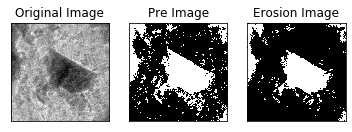

In [73]:
if mode == 1: ### image segmentation
    ret, pre_img = cv2.threshold(img,255,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
elif mode == 2: ### add brightness and contrast
    pre_img = apply_brightness_contrast(img, 50, 135)
elif mode ==3: ## edge detection
    pre_image = cv2.Canny(img, 30, 150)
elif mode == 4: ### thresholding
    pre_image = cv2.threshold(img,0,255,cv2.THRESH_BINARY)

### Erosion
kernel = np.ones((2, 2), np.uint8)
erode_img = cv2.erode(pre_img, kernel)
showImage(img, 'Original Image', pre_img, 'Pre Image', erode_img, 'Erosion Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

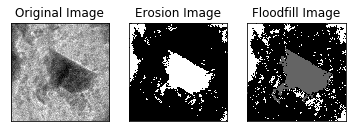

In [75]:
### flood fill
H, W = img.shape
mask = np.zeros((H+2, W+2), np.uint8)
fill_img = pre_img.copy()
cv2.floodFill(fill_img, mask, (round(H/2), round(W/2)), 100) ## assume cell-to-detect is in the center
showImage(img, 'Original Image', erode_img, 'Erosion Image', fill_img, 'Floodfill Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

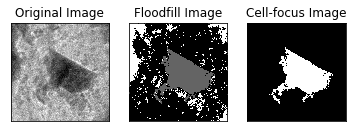

In [76]:
### focus to cell
cell_img = fill_img.copy()
for i in range(H):
    for j in range(W):
        if cell_img[i, j] != 100:
            cell_img[i, j] = 0
        else:
            cell_img[i, j] = 255
showImage(img, 'Original Image', fill_img, 'Floodfill Image', cell_img, 'Cell-focus Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

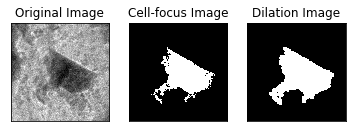

In [77]:
### dilation
kernel = np.ones((10, 10), np.uint8)
dilate_img = cv2.dilate(cell_img, kernel)
showImage(img, 'Original Image', cell_img, 'Cell-focus Image', dilate_img, 'Dilation Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

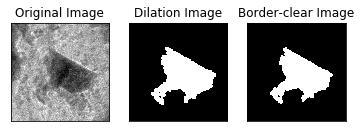

In [78]:
### clean border
cleanBor_img = cv2.copyMakeBorder(dilate_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255])
e_H, e_W = cleanBor_img.shape
e_mask = np.zeros((e_H+2, e_W+2), np.uint8)
cv2.floodFill(cleanBor_img, e_mask, (5, 5), (0),flags=cv2.FLOODFILL_FIXED_RANGE)
showImage(img, 'Original Image', dilate_img, 'Dilation Image', cleanBor_img, 'Border-clear Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

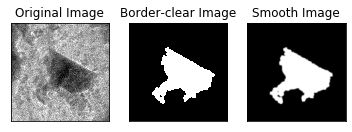

In [79]:
### smooth
smooth_img = cv2.GaussianBlur(cleanBor_img, (15, 15), 0)
showImage(img, 'Original Image', cleanBor_img, 'Border-clear Image', smooth_img, 'Smooth Image')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

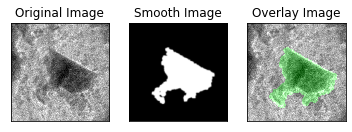

In [80]:
### change mask color
final_mask = np.zeros((H, W, 3), np.uint8)
area = 0
for i in range(H):
    for j in range(W):
        if smooth_img[i, j] != 0:
            final_mask[i, j, :] = (0, 255, 0)
            area += 1
        else:
            final_mask[i, j, :] = (0, 0, 0)

### change original image to RGB channel
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

### overlay image
overlay_img = cv2.addWeighted(img_rgb, 1, final_mask, 0.3, 0)
showImage(img, 'Original Image', smooth_img, 'Smooth Image', overlay_img, 'Overlay Image')
plt.show